In [1]:
import os
import torch
import librosa
import numpy as np
from torch.utils.data import DataLoader
import torch.nn as nn

In [2]:
class MusicDataset(torch.utils.data.Dataset):
    def __init__(self, mix_dir, synth_dir, sr=22050, n_mels=128, num_samples=150):
        self.mix_dir = mix_dir
        self.synth_dir = synth_dir
        self.sr = sr
        self.duration = 30  # Duration in seconds
        self.n_mels = n_mels
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        mix_file = f'mix_{idx}.wav'
        synth_file = f'synth_{idx}.wav'
        
        mix_path = os.path.join(self.mix_dir, mix_file)
        synth_path = os.path.join(self.synth_dir, synth_file)

        # Load audio files
        mix, _ = librosa.load(mix_path, sr=self.sr, duration=self.duration)
        synth, _ = librosa.load(synth_path, sr=self.sr, duration=self.duration)

        # Convert to Mel spectrogram
        mix_mel = librosa.feature.melspectrogram(y=mix, sr=self.sr, n_mels=self.n_mels)
        synth_mel = librosa.feature.melspectrogram(y=synth, sr=self.sr, n_mels=self.n_mels)

        # Convert to decibels
        mix_db = librosa.power_to_db(mix_mel, ref=np.max)
        synth_db = librosa.power_to_db(synth_mel, ref=np.max)

        max_length = 1292  # This should be set to the length of your longest spectrogram

        # Pad the spectrograms to have the same length
        mix_db_padded = self._pad_spectrogram(mix_db, max_length)
        synth_db_padded = self._pad_spectrogram(synth_db, max_length)

        return torch.tensor(mix_db_padded, dtype=torch.float32), torch.tensor(synth_db_padded, dtype=torch.float32)


    def _pad_spectrogram(self, spectrogram, max_length):
        padding_length = max_length - spectrogram.shape[1]
        if padding_length > 0:
            return np.pad(spectrogram, ((0, 0), (0, padding_length)), 'constant')
        return spectrogram


In [2]:
class SynthLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SynthLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        lstm_out, _ = self.lstm(x, (h0, c0))

        # Transform lstm_out to have same shape as target data
        out = self.fc(lstm_out)  # Apply linear layer to each time step
        return out


In [4]:
def train_model(model, data_loader, learning_rate, epochs, device):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(epochs):
        for i, (mix, synth) in enumerate(data_loader):
            # Reshape data to match LSTM input
            mix = mix.to(device).transpose(1, 2)  # Reshape to [batch_size, seq_len, feature_size]
            synth = synth.to(device).transpose(1, 2)

            # Forward pass
            outputs = model(mix)
            loss = criterion(outputs, synth)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 100 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(data_loader)}], Loss: {loss.item()}')

In [3]:
# Hyperparameters
feature_size = 128  # Number of Mel bands
seq_len = 1292  # Sequence length (number of frames in spectrogram)
hidden_size = 128
output_size = feature_size  # Output should match the number of Mel bands
num_layers = 2
learning_rate = 0.001
epochs = 10
batch_size = 4

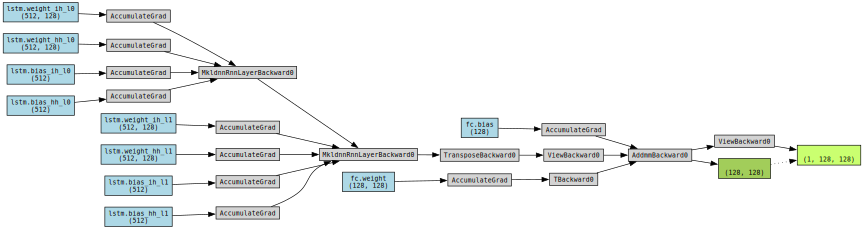

In [11]:
from torchviz import make_dot

batch_size = 1
seq_len = 128  # Number of time frames in Mel Spectrogram
n_mels = 128   # Number of Mel bands

x_lstm = torch.randn(batch_size, seq_len, n_mels)
model = SynthLSTM(feature_size, hidden_size, output_size, num_layers)

out = model(x_lstm)

dot = make_dot(out, params=dict(list(model.named_parameters()) + [('x', x_lstm)]))
dot.attr(rankdir='LR')  # LR for left-to-right, TB for top-to-bottom
# dot.attr(size='10,10')
dot

# dot = make_dot(out, params=dict(model.named_parameters()))
# dot.render('./model_architecture', format='png')  # Saves the diagram as 'model_architecture.png'
# dot

In [ ]:

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)
# Dataset and DataLoader
mix_dir = r'F:\Study\EE641\Dataset\musdb18\mix'
synth_dir = r'F:\Study\EE641\Dataset\musdb18\synth'
music_dataset = MusicDataset(mix_dir, synth_dir)
music_dataloader = DataLoader(music_dataset, batch_size=batch_size, shuffle=True)

# Model
model = SynthLSTM(feature_size, hidden_size, output_size, num_layers).to(device)

# Train the model
train_model(model, music_dataloader, learning_rate, epochs, device)

In [28]:
mix, synth = music_dataset[0]
print(mix.shape)

0 torch.Size([128, 1292])
